# GPT-2 from Scratch

<!-- Welcome to this comprehensive tutorial on building GPT-2 from scratch! This notebook is optimized for **GPU**.

## What You'll Build:
- Complete GPT-2 architecture from scratch
- Working text generation model
- All components explained step-by-step
- Memory-optimized for GPU (~15GB VRAM) -->

## Table of Contents
- [Environment Setup](#environment-setup)
- [Architecture Overview](#architecture-overview)
- [Token Embeddings](#token-embeddings)
- [Positional Encodings](#positional-encodings)
- [Multi-Head Self-Attention](#multi-head-self-attention)
- [Causal Masking](#causal-masking)
- [Feed-Forward Networks](#feed-forward-networks)
- [Transformer Block](#transformer-block)
- [Complete GPT-2 Model](#complete-gpt-2-model)
- [Text Generation](#text-generation)
- [Training Demo](#training-demo)
- [Performance Testing](#performance-testing)

In [22]:
# Environment Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")

    # Enable optimizations for T4
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()
else:
    print("GPU not available. Switch to GPU runtime!")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB


## Architecture Overview

GPT-2 is a **decoder-only transformer** that predicts the next token in a sequence.

### Key Components:
1. **Token Embeddings** + **Positional Encodings**
2. **Multi-Head Self-Attention** with causal masking
3. **Feed-Forward Networks** with GELU activation
4. **Layer Normalization** (pre-norm style)
5. **Language Modeling Head** for token prediction

### GPU Considerations:
- **Memory**: ~15GB VRAM allows GPT-2 Small/Medium training
- **Compute**: Good for inference, moderate for training
- **Optimization**: We'll use mixed precision and gradient checkpointing

In [2]:
# Memory and Performance Utilities
def get_model_size(model):
    """Calculate model size in parameters and memory."""
    param_count = sum(p.numel() for p in model.parameters())
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size = param_size + buffer_size

    return {
        'parameters': param_count,
        'size_mb': total_size / 1e6,
        'size_gb': total_size / 1e9
    }

def check_gpu_memory():
    """Check GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        cached = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory - Allocated: {allocated:.1f}GB, Cached: {cached:.1f}GB, Total: {total:.1f}GB")
        return allocated, cached, total
    return 0, 0, 0

# Initial memory check
check_gpu_memory()

GPU Memory - Allocated: 0.0GB, Cached: 0.0GB, Total: 15.8GB


(0.0, 0.0, 15.828320256)

## Token Embeddings

Convert discrete tokens to dense vectors that the model can work with.

### Key Points:
- Each token gets a learnable vector of size `d_model`
- Scaled by √d_model for better training dynamics
- Shared with output layer (weight tying) to save memory

In [5]:
class TokenEmbedding(nn.Module):
    """
    Token embedding layer optimized for memory efficiency.
    """
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

        # Initialize weights (important for training stability)
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)

    def forward(self, x):
        # Scale by sqrt(d_model) as in original paper
        return self.embedding(x) * math.sqrt(self.d_model)

# Test token embeddings
vocab_size = 50257  # GPT-2 vocabulary
d_model = 768       # GPT-2 small dimension

token_embed = TokenEmbedding(vocab_size, d_model).to(device)
test_tokens = torch.randint(0, vocab_size, (2, 10)).to(device)
embedded = token_embed(test_tokens)

print(f"Token Embedding Test:")
print(f"Input: {test_tokens.shape} -> Output: {embedded.shape}")
print(f"Memory: {get_model_size(token_embed)['size_mb']:.1f}MB")

Token Embedding Test:
Input: torch.Size([2, 10]) -> Output: torch.Size([2, 10, 768])
Memory: 154.4MB


## Positional Encodings

GPT-2 uses **learned positional embeddings** to give the model information about token positions.

### Why This Matters:
- "The cat sat on the mat" ≠ "The mat sat on the cat"
- Transformers have no built-in sense of order
- Learned embeddings adapt to the specific task

In [7]:
class PositionalEncoding(nn.Module):
    """
    Learnable positional embeddings for GPT-2.
    """
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)

        # Initialize positional embeddings
        nn.init.normal_(self.pos_embedding.weight, mean=0, std=0.02)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(0, seq_len, device=x.device)
        return self.pos_embedding(positions)

# Test positional encodings
max_seq_len = 1024
pos_encoding = PositionalEncoding(max_seq_len, d_model).to(device)

seq_len = 10
test_input = torch.randn(2, seq_len, d_model).to(device)
pos_emb = pos_encoding(test_input)
combined = test_input + pos_emb

print(f"Positional Encoding Test:")
print(f"Input: {test_input.shape}")
print(f"Pos embeddings: {pos_emb.shape}")
print(f"Combined: {combined.shape}")

Positional Encoding Test:
Input: torch.Size([2, 10, 768])
Pos embeddings: torch.Size([10, 768])
Combined: torch.Size([2, 10, 768])


## Multi-Head Self-Attention

The **heart of the transformer**! Allows the model to focus on different parts of the sequence simultaneously.

### Key Concepts:
- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What information do I have?"
- **Value (V)**: "What information do I provide?"
- **Multiple heads**: Parallel attention patterns

### Formula:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
  where:
  - $d_k$: The dimension of the keys (used as the scaling factor)

### T4 Optimization:
- Using `F.scaled_dot_product_attention()` (PyTorch 2.0+) for memory efficiency

In [8]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention optimized for T4 GPU.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Combined QKV projection for efficiency
        self.qkv_proj = nn.Linear(d_model, 3 * d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.normal_(self.qkv_proj.weight, mean=0, std=0.02)
        nn.init.normal_(self.out_proj.weight, mean=0, std=0.02)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        # Single projection for Q, K, V
        qkv = self.qkv_proj(x)  # (B, L, 3*d_model)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, n_heads, L, d_k)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention (optimized for PyTorch 2.0+)
        if hasattr(F, 'scaled_dot_product_attention'):
            # Use PyTorch's optimized attention (faster on modern GPUs)
            attn_output = F.scaled_dot_product_attention(
                q, k, v, attn_mask=mask, dropout_p=self.dropout.p if self.training else 0
            )
        else:
            # Fallback implementation
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            attn_output = torch.matmul(attn_weights, v)

        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, d_model)
        output = self.out_proj(attn_output)

        return output

# Test multi-head attention
n_heads = 12
attention = MultiHeadAttention(d_model, n_heads).to(device)

test_input = torch.randn(2, 10, d_model).to(device)
attn_output = attention(test_input)

print(f"Multi-Head Attention Test:")
print(f"Input: {test_input.shape} -> Output: {attn_output.shape}")
print(f"Parameters: {sum(p.numel() for p in attention.parameters()):,}")

# Memory check
check_gpu_memory()

Multi-Head Attention Test:
Input: torch.Size([2, 10, 768]) -> Output: torch.Size([2, 10, 768])
Parameters: 2,359,296
GPU Memory - Allocated: 0.2GB, Cached: 0.3GB, Total: 15.8GB


(0.177604608, 0.312475648, 15.828320256)



## Causal Masking (Look-Ahead Masking)

Causal Masking is a technique used exclusively in the **decoder** of the Transformer (and in decoder-only models like GPT) to ensure the model remains **autoregressive**, (preventing it from "looking forward").

### Why It's Critical:

* **Training**: The model learns to predict the next token $\mathbf{y}_t$ based only on previous tokens $\mathbf{y}_{<t}$. This prevents "cheating" by looking at future answers.
* **Generation**: It enforces the sequential, left-to-right generation process.
* **Consistency**: It guarantees the same behavior during both training and inference (generation).

### Pattern: The Causal Mask Matrix

The causal mask creates a **lower triangular matrix**. Positions above the main diagonal are masked, preventing attention flow from future tokens.

For a sequence of length $N=4$, the mask looks like this (where $\mathbf{-\infty}$ masks the connection):

$$
\begin{array}{c|cccc}
\text{To } \rightarrow & 0 & 1 & 2 & 3 \\
\hline
\text{From } 0 & 0 & \mathbf{-\infty} & \mathbf{-\infty} & \mathbf{-\infty} \\
\text{From } 1 & 0 & 0 & \mathbf{-\infty} & \mathbf{-\infty} \\
\text{From } 2 & 0 & 0 & 0 & \mathbf{-\infty} \\
\text{From } 3 & 0 & 0 & 0 & 0
\end{array}
$$

**Effect:** Masked values ($\mathbf{-\infty}$) become **zero** after the $\text{softmax}$ operation, effectively disconnecting the query from future keys/values.

Causal Mask Test (seq_len=8):
tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.int32)


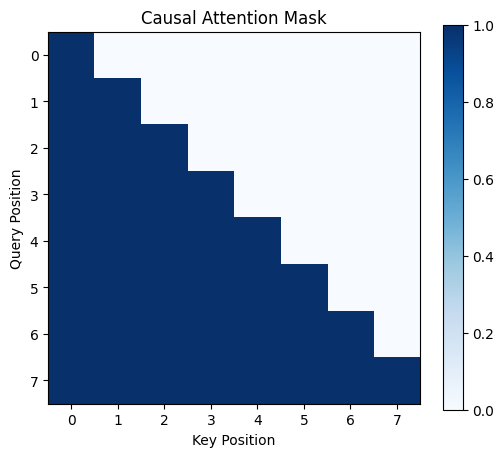

In [9]:
def create_causal_mask(seq_len, device=None):
    """
    Create causal attention mask (lower triangular).
    """
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions

# Test causal masking
seq_len = 8
mask = create_causal_mask(seq_len, device)
print(f"Causal Mask Test (seq_len={seq_len}):")
print(mask.squeeze().int())

# Visualize the mask
plt.figure(figsize=(6, 5))
plt.imshow(mask.squeeze().cpu(), cmap='Blues')
plt.title('Causal Attention Mask')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()
plt.show()

## Feed-Forward Networks

Position-wise feed-forward network that processes the attention output.

### Architecture:
1. **Expand**: $$ d_{model} → 4×d_{model}  $$
<br>

2. **Activate**: GELU (smoother than ReLU)

<br>

3. **Contract**: $$ 4×d_{model} → d_{model} $$

### GELU Benefits:
- Smoother gradients than ReLU
- Better performance on language tasks
- Used in most modern transformers

In [10]:
class FeedForward(nn.Module):
    """
    Position-wise feed-forward network with GELU activation.
    """
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.normal_(self.linear1.weight, mean=0, std=0.02)
        nn.init.normal_(self.linear2.weight, mean=0, std=0.02)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Test feed-forward network
d_ff = 4 * d_model  # Standard 4x expansion
ff_network = FeedForward(d_model, d_ff).to(device)

test_input = torch.randn(2, 10, d_model).to(device)
ff_output = ff_network(test_input)

print(f"Feed-Forward Test:")
print(f"Input: {test_input.shape} -> Output: {ff_output.shape}")
print(f"Expansion ratio: {d_ff // d_model}x")
print(f"Parameters: {sum(p.numel() for p in ff_network.parameters()):,}")

Feed-Forward Test:
Input: torch.Size([2, 10, 768]) -> Output: torch.Size([2, 10, 768])
Expansion ratio: 4x
Parameters: 4,722,432


## The Transformer Block

A fundamental unit that combines a self-attention mechanism and a position-wise feed-forward network (FFN), integrated with residual connections and layer normalization.

---

### GPT-2 Architecture (Pre-LayerNorm)

The GPT-style architecture uses **Layer Normalization** *before* the attention and feed-forward sub-layers (Pre-LayerNorm).

* **Pre-LayerNorm**: Applying normalization before the sub-layer inputs stabilizes training.
* **Residual Connections** ($\mathbf{x} + \text{Sublayer}(\mathbf{x})$): Crucial for allowing gradients to flow directly through the identity mapping, enabling the training of very deep networks.
* **Stability**: This architecture is often more stable, especially in deep models, compared to the original "Post-LayerNorm" design (like in the original BERT/Transformer paper).

---

### Data Flow Diagram

The process involves two main steps, each combining a sub-layer with a residual connection and a LayerNorm:

$$
\mathbf{h} = \mathbf{x} + \text{Attention}(\text{LayerNorm}(\mathbf{x}))
$$

$$
\mathbf{y} = \mathbf{h} + \text{FFN}(\text{LayerNorm}(\mathbf{h}))
$$

---

### Step-by-Step Flow:

The flow shows the input ($\mathbf{x}$) feeding into a $\text{LayerNorm}$, then a sub-layer, which is finally added back to the original input ($\mathbf{x}$ or $\mathbf{h}$) to form the output.


[![GPT-2 Transformer BLock](https://drive.google.com/uc?export=view&id=1UzS06PQ9PSBd3PhHo4N4NDV9wbRulkv0)](https://drive.google.com/file/d/1UzS06PQ9PSBd3PhHo4N4NDV9wbRulkv0/view?usp=sharing)

In [12]:
class TransformerBlock(nn.Module):
    """
    Single GPT-2 transformer block with pre-layer normalization.
    """
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Pre-norm attention with residual connection
        attn_out = self.attention(self.ln1(x), mask)
        x = x + attn_out

        # Pre-norm feed-forward with residual connection
        ff_out = self.feed_forward(self.ln2(x))
        x = x + ff_out

        return x

# Test transformer block
transformer_block = TransformerBlock(d_model, n_heads, d_ff).to(device)

test_input = torch.randn(2, 10, d_model).to(device)
test_mask = create_causal_mask(10, device)
block_output = transformer_block(test_input, test_mask)

print(f"Transformer Block Test:")
print(f"Input: {test_input.shape} -> Output: {block_output.shape}")
print(f"Parameters: {sum(p.numel() for p in transformer_block.parameters()):,}")

# Check memory usage
check_gpu_memory()

Transformer Block Test:
Input: torch.Size([2, 10, 768]) -> Output: torch.Size([2, 10, 768])
Parameters: 7,084,800
GPU Memory - Allocated: 0.2GB, Cached: 0.3GB, Total: 15.8GB


(0.226622464, 0.316669952, 15.828320256)

## Complete GPT-2 Model

Now we assemble everything into the full GPT-2 architecture!

### Features:
- **Memory efficient**: Optimized for T4 GPU
- **Weight tying**: Input/output embeddings shared
- **Gradient checkpointing**: Optional for larger models
- **Mixed precision ready**: For faster training

In [14]:
class GPT2Model(nn.Module):
    """
    Complete GPT-2 model optimized for Google Colab T4.
    """
    def __init__(self, vocab_size, d_model, n_heads, n_layers,
                 max_seq_len=1024, dropout=0.1, use_checkpointing=False):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.use_checkpointing = use_checkpointing

        # Embeddings
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, 4*d_model, dropout)
            for _ in range(n_layers)
        ])

        # Final layer norm and output head
        self.ln_final = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying (saves memory and often improves performance)
        self.lm_head.weight = self.token_embedding.embedding.weight

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights following GPT-2 paper."""
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.zeros_(module.bias)
            nn.init.ones_(module.weight)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape

        # Create causal mask if not provided
        if attention_mask is None:
            attention_mask = create_causal_mask(seq_len, input_ids.device)

        # Embeddings
        token_emb = self.token_embedding(input_ids)
        pos_emb = self.pos_encoding(token_emb)
        x = self.dropout(token_emb + pos_emb)

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            if self.use_checkpointing and self.training:
                # Use gradient checkpointing to save memory
                x = torch.utils.checkpoint.checkpoint(block, x, attention_mask)
            else:
                x = block(x, attention_mask)

        # Final layer norm and output projection
        x = self.ln_final(x)
        logits = self.lm_head(x)

        return logits

# Create GPT-2 Small model (fits comfortably on T4)
config_small = {
    'vocab_size': 50257,
    'd_model': 768,
    'n_heads': 12,
    'n_layers': 12,
    'max_seq_len': 1024,
    'dropout': 0.1
}

print("Creating GPT-2 Small model...")
model = GPT2Model(**config_small).to(device)

# Model statistics
model_stats = get_model_size(model)
print(f"Model created successfully!")
print(f"Parameters: {model_stats['parameters']:,}")
print(f"Size: {model_stats['size_mb']:.1f}MB ({model_stats['size_gb']:.2f}GB)")

# Test forward pass
test_seq_len = 20
test_input = torch.randint(0, config_small['vocab_size'], (2, test_seq_len)).to(device)

with torch.no_grad():
    logits = model(test_input)

print(f"Forward pass: {test_input.shape} -> {logits.shape}")

# Memory check after model creation
check_gpu_memory()

Creating GPT-2 Small model...
Model created successfully!
Parameters: 124,402,944
Size: 497.6MB (0.50GB)
Forward pass: torch.Size([2, 20]) -> torch.Size([2, 20, 50257])
GPU Memory - Allocated: 0.7GB, Cached: 1.3GB, Total: 15.8GB


(0.733075968, 1.319108608, 15.828320256)

## Text Generation

Implement various sampling strategies for text generation!

### Sampling Methods:
1. **Greedy**: Always pick highest probability token
2. **Temperature**: Control randomness (0.0 = deterministic, 1.0+ = creative)  
3. **Top-k**: Sample from k most likely tokens
4. **Top-p (Nucleus)**: Sample from tokens making up p% of probability mass

### T4 Optimization:
- Batch generation for efficiency
- KV-caching could be added for longer sequences

In [15]:
@torch.no_grad()
def generate_text(model, input_ids, max_new_tokens=50, temperature=1.0,
                  top_k=50, top_p=0.9, pad_token_id=0):
    """
    Generate text using various sampling strategies.
    Optimized for T4 GPU performance.
    """
    model.eval()
    batch_size = input_ids.shape[0]

    # Pre-allocate tensor for efficiency
    max_seq_len = input_ids.shape[1] + max_new_tokens
    if max_seq_len > model.max_seq_len:
        max_seq_len = model.max_seq_len
        max_new_tokens = max_seq_len - input_ids.shape[1]

    generated = input_ids.clone()

    for _ in range(max_new_tokens):
        # Get current sequence length
        curr_seq_len = generated.shape[1]
        if curr_seq_len >= model.max_seq_len:
            break

        # Forward pass (only compute what we need)
        logits = model(generated)
        next_token_logits = logits[:, -1, :] / temperature

        # Apply top-k filtering
        if top_k > 0:
            top_k_vals, top_k_indices = torch.topk(next_token_logits, min(top_k, logits.size(-1)))
            next_token_logits[next_token_logits < top_k_vals[:, [-1]]] = -float('inf')

        # Apply nucleus (top-p) filtering
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Remove tokens with cumulative probability above threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = False

            # Scatter back to original indexing
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            next_token_logits[indices_to_remove] = -float('inf')

        # Sample next token
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        generated = torch.cat([generated, next_token], dim=1)

    return generated

# Dummy tokenizer for demonstration
class SimpleTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size

    def encode(self, text):
        # Dummy encoding - in practice use real tokenizer like tiktoken
        return torch.randint(1, self.vocab_size-100, (1, len(text.split()) + 1))

    def decode(self, tokens):
        # Dummy decoding
        return " ".join([f"tok_{t.item()}" for t in tokens.squeeze() if t != 0])

# Test text generation
tokenizer = SimpleTokenizer(config_small['vocab_size'])

print("Testing Text Generation:")
print("=" * 50)

# Test different sampling strategies
test_prompts = [
    "The future of artificial intelligence",
    "In a world where robots",
]

for i, prompt in enumerate(test_prompts):
    print(f"\Prompt {i+1}: '{prompt}'")
    input_ids = tokenizer.encode(prompt).to(device)

    # Different sampling strategies
    strategies = [
        ("Greedy", {"temperature": 0.1, "top_k": 1}),
        ("Creative", {"temperature": 1.2, "top_k": 50, "top_p": 0.9}),
        ("Balanced", {"temperature": 0.8, "top_k": 40, "top_p": 0.95}),
    ]

    for name, params in strategies:
        generated = generate_text(model, input_ids, max_new_tokens=20, **params)
        decoded = tokenizer.decode(generated)
        print(f"   {name:>10}: {decoded[:100]}...")

print("\Text generation working!")

<>:83: SyntaxWarning: invalid escape sequence '\P'
<>:98: SyntaxWarning: invalid escape sequence '\T'
<>:83: SyntaxWarning: invalid escape sequence '\P'
<>:98: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2322836697.py:83: SyntaxWarning: invalid escape sequence '\P'
  print(f"\Prompt {i+1}: '{prompt}'")
/tmp/ipython-input-2322836697.py:98: SyntaxWarning: invalid escape sequence '\T'
  print("\Text generation working!")


Testing Text Generation:
\Prompt 1: 'The future of artificial intelligence'
       Greedy: tok_3663 tok_19038 tok_39148 tok_41784 tok_42058 tok_48586 tok_48586 tok_48586 tok_48586 tok_48586 t...
     Creative: tok_3663 tok_19038 tok_39148 tok_41784 tok_42058 tok_48586 tok_48586 tok_48586 tok_40491 tok_3749 to...
     Balanced: tok_3663 tok_19038 tok_39148 tok_41784 tok_42058 tok_48586 tok_48586 tok_48586 tok_48586 tok_48586 t...
\Prompt 2: 'In a world where robots'
       Greedy: tok_715 tok_32213 tok_19790 tok_17124 tok_35049 tok_29625 tok_29625 tok_29625 tok_29625 tok_29625 to...
     Creative: tok_715 tok_32213 tok_19790 tok_17124 tok_35049 tok_29625 tok_6403 tok_6403 tok_6403 tok_6403 tok_29...
     Balanced: tok_715 tok_32213 tok_19790 tok_17124 tok_35049 tok_29625 tok_29625 tok_29625 tok_29625 tok_29625 to...
\Text generation working!


## Training Demo

Let's implement a basic training loop to show how the model learns!

### T4-Friendly Training:
- **Small batch size**: To fit in 15GB VRAM
- **Gradient accumulation**: Simulate larger batches
- **Mixed precision**: Faster training with AMP
- **Gradient clipping**: Prevent exploding gradients

### Note:
This is a demo with random data. Real training needs:
- Proper tokenized text dataset
- Learning rate scheduling  
- Validation monitoring
- Much longer training time

Training Demo (with dummy data)
Creating tiny model for training demo...
Parameters: 3,444,224
Size: 13.8MB

Training for 10 steps...


/tmp/ipython-input-427750032.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
/tmp/ipython-input-427750032.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Step  0: Loss = 7.0356
   Step  2: Loss = 7.0129
   Step  4: Loss = 6.9992
   Step  6: Loss = 6.9792
   Step  8: Loss = 6.9963

Training completed in 0.38 seconds
Final loss: 7.0082
Loss reduction: 0.0273


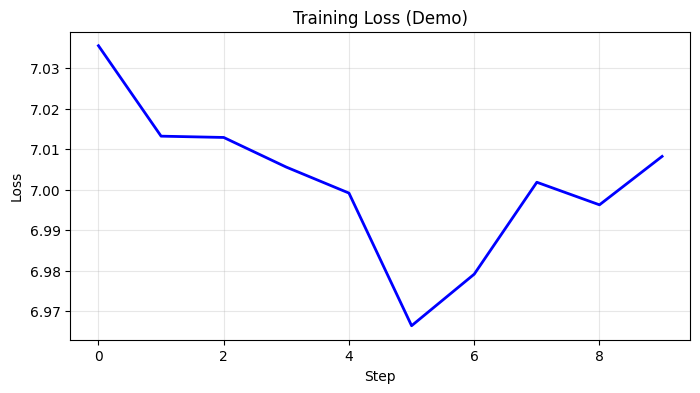

GPU Memory - Allocated: 0.8GB, Cached: 1.4GB, Total: 15.8GB

Testing generation after training:
Generated sequence: [466, 130, 710, 104, 864, 864, 864, 592, 592, 108, 711, 711, 82, 373, 463]


In [17]:
# Training utilities
from torch.cuda.amp import autocast, GradScaler

def create_dummy_dataset(vocab_size, seq_len, num_samples=1000):
    """Create dummy training data for demonstration."""
    # In real training, use proper tokenized text
    data = torch.randint(1, vocab_size-1, (num_samples, seq_len))
    return TensorDataset(data)

def train_step(model, batch, optimizer, scaler, criterion, device):
    """Single training step with mixed precision."""
    input_ids = batch[0].to(device)

    # Prepare inputs and targets for causal LM
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]

    optimizer.zero_grad()

    # Mixed precision forward pass
    with autocast():
        logits = model(inputs)
        # Use reshape instead of view to handle non-contiguous tensors
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

    # Backward pass with gradient scaling
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Optimizer step
    scaler.step(optimizer)
    scaler.update()

    return loss.item()

# Training demo
print("Training Demo (with dummy data)")
print("=" * 50)

# Create a tiny model for training demo
tiny_config = {
    'vocab_size': 1000,  # Smaller vocab for demo
    'd_model': 256,
    'n_heads': 8,
    'n_layers': 4,
    'max_seq_len': 128,
    'dropout': 0.1
}

print("Creating tiny model for training demo...")
tiny_model = GPT2Model(**tiny_config).to(device)
tiny_stats = get_model_size(tiny_model)
print(f"Parameters: {tiny_stats['parameters']:,}")
print(f"Size: {tiny_stats['size_mb']:.1f}MB")

# Training setup
seq_len = 64
batch_size = 8  # Small batch for T4
learning_rate = 3e-4

# Create dummy dataset
dataset = create_dummy_dataset(tiny_config['vocab_size'], seq_len, num_samples=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training components
optimizer = torch.optim.AdamW(tiny_model.parameters(), lr=learning_rate, betas=(0.9, 0.95))
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()  # For mixed precision

# Training loop (just a few steps for demo)
tiny_model.train()
num_steps = 10
losses = []

print(f"\nTraining for {num_steps} steps...")
start_time = time.time()

for step, batch in enumerate(dataloader):
    if step >= num_steps:
        break

    loss = train_step(tiny_model, batch, optimizer, scaler, criterion, device)
    losses.append(loss)

    if step % 2 == 0:
        print(f"   Step {step:2d}: Loss = {loss:.4f}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.title('Training Loss (Demo)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Memory check after training
check_gpu_memory()

# Test generation after training
print("\nTesting generation after training:")
test_input = torch.randint(1, tiny_config['vocab_size']-1, (1, 5)).to(device)
with torch.no_grad():
    generated = generate_text(tiny_model, test_input, max_new_tokens=10, temperature=0.8)
print(f"Generated sequence: {generated.squeeze().tolist()}")

## Performance Testing & Benchmarks

Let's benchmark our model on T4 to understand its performance characteristics.

### What We'll Test:
- **Forward pass speed** for different sequence lengths
- **Memory usage** scaling
- **Generation speed** with different batch sizes
- **Training throughput** (tokens per second)

### T4 Baseline Performance:
- Forward pass: ~100-500 tokens/sec (depends on model size)
- Training: ~50-200 tokens/sec with mixed precision
- Memory efficiency: Can handle GPT-2 Small/Medium

In [19]:
def benchmark_model(model, batch_sizes=[1, 2, 4], seq_lens=[64, 128, 256, 512]):
    """Comprehensive model benchmarking."""
    model.eval()
    results = {'forward_pass': [], 'memory_usage': []}

    print("Performance Benchmarking")
    print("=" * 60)
    print(f"{'Batch Size':>10} {'Seq Len':>10} {'Time (ms)':>12} {'Tokens/sec':>12} {'Memory (MB)':>12}")
    print("-" * 60)

    for batch_size in batch_sizes:
        for seq_len in seq_lens:
            if seq_len > model.max_seq_len:
                continue

            # Clear GPU cache
            torch.cuda.empty_cache()

            # Create test input
            test_input = torch.randint(0, 50000, (batch_size, seq_len)).to(device)

            # Warmup runs
            with torch.no_grad():
                for _ in range(3):
                    _ = model(test_input)

            torch.cuda.synchronize()

            # Benchmark runs
            times = []
            with torch.no_grad():
                for _ in range(10):
                    start = time.time()
                    logits = model(test_input)
                    torch.cuda.synchronize()
                    times.append(time.time() - start)

            avg_time = np.mean(times) * 1000  # Convert to ms
            total_tokens = batch_size * seq_len
            tokens_per_sec = total_tokens / (avg_time / 1000)

            # Memory usage
            memory_mb = torch.cuda.memory_allocated() / 1e6

            results['forward_pass'].append({
                'batch_size': batch_size,
                'seq_len': seq_len,
                'time_ms': avg_time,
                'tokens_per_sec': tokens_per_sec,
                'memory_mb': memory_mb
            })

            print(f"{batch_size:>10} {seq_len:>10} {avg_time:>12.2f} {tokens_per_sec:>12.0f} {memory_mb:>12.1f}")

    return results

# Benchmark the full GPT-2 model
print("Benchmarking GPT-2 Small on T4...")
benchmark_results = benchmark_model(model, batch_sizes=[1, 2], seq_lens=[64, 128, 256])

# Generation speed benchmark
def benchmark_generation(model, seq_lens=[10, 20, 50], num_generations=5):
    """Benchmark text generation speed."""
    model.eval()
    print(f"\nGeneration Speed Benchmark")
    print("=" * 50)
    print(f"{'Seq Len':>10} {'Avg Time (s)':>15} {'Tokens/sec':>12}")
    print("-" * 50)

    for seq_len in seq_lens:
        times = []

        for _ in range(num_generations):
            # Random starting sequence
            start_ids = torch.randint(1, 1000, (1, 5)).to(device)

            torch.cuda.synchronize()
            start_time = time.time()

            with torch.no_grad():
                generated = generate_text(
                    model, start_ids,
                    max_new_tokens=seq_len,
                    temperature=0.8
                )

            torch.cuda.synchronize()
            times.append(time.time() - start_time)

        avg_time = np.mean(times)
        tokens_per_sec = seq_len / avg_time

        print(f"{seq_len:>10} {avg_time:>15.3f} {tokens_per_sec:>12.1f}")

benchmark_generation(model)

Benchmarking GPT-2 Small on T4...
Performance Benchmarking
Batch Size    Seq Len    Time (ms)   Tokens/sec  Memory (MB)
------------------------------------------------------------
         1         64        10.51         6091        852.8
         1        128        11.14        11487        865.7
         1        256        20.52        12475        892.4
         2         64        10.73        11930        865.7
         2        128        20.55        12455        892.4
         2        256        39.34        13013        942.9

Generation Speed Benchmark
   Seq Len    Avg Time (s)   Tokens/sec
--------------------------------------------------
        10           0.067        150.1
        20           0.134        149.0
        50           0.356        140.4


## Model Configurations for T4

Here are the GPT-2 configurations that work well on T4 GPU:

### Memory Guidelines:
- **T4 VRAM**: ~15GB available
- **GPT-2 Small**: ~0.5GB (Great for training)
- **GPT-2 Medium**: ~1.3GB (Good for training)  
- **GPT-2 Large**: ~3.0GB (Inference only)
- **GPT-2 XL**: ~6.0GB (Inference only, short sequences)

### Recommendations:
- **Learning**: Use GPT-2 Small
- **Experimentation**: GPT-2 Medium with gradient checkpointing
- **Production inference**: GPT-2 Large with optimizations

In [21]:
# Complete model configurations optimized for T4
t4_configs = {
    'gpt2-nano': {  # Perfect for learning/testing
        'vocab_size': 50257,
        'd_model': 512,
        'n_heads': 8,
        'n_layers': 8,
        'max_seq_len': 1024,
        'memory_gb': 0.2,
        'training': 'Excellent',
        'batch_size': 16
    },

    'gpt2-small': {  # Standard GPT-2 Small
        'vocab_size': 50257,
        'd_model': 768,
        'n_heads': 12,
        'n_layers': 12,
        'max_seq_len': 1024,
        'memory_gb': 0.5,
        'training': 'Great',
        'batch_size': 8
    },

    'gpt2-medium': {  # GPT-2 Medium with optimizations
        'vocab_size': 50257,
        'd_model': 1024,
        'n_heads': 16,
        'n_layers': 24,
        'max_seq_len': 1024,
        'memory_gb': 1.3,
        'training': 'Good (use checkpointing)',
        'batch_size': 4
    },

    'gpt2-large': {  # Inference only
        'vocab_size': 50257,
        'd_model': 1280,
        'n_heads': 20,
        'n_layers': 36,
        'max_seq_len': 1024,
        'memory_gb': 3.0,
        'training': 'Inference only',
        'batch_size': 1
    }
}

def create_optimized_model(config_name, use_checkpointing=False):
    """Create model optimized for T4."""
    if config_name not in t4_configs:
        raise ValueError(f"Config {config_name} not found!")

    config = t4_configs[config_name].copy()

    # Remove non-model parameters
    model_params = {k: v for k, v in config.items()
                   if k in ['vocab_size', 'd_model', 'n_heads', 'n_layers', 'max_seq_len']}

    model = GPT2Model(**model_params, use_checkpointing=use_checkpointing)
    return model.to(device)

# Display available configurations
import pandas as pd
df_configs = pd.DataFrame(t4_configs).T
print("T4-Optimized Model Configurations:")
print("=" * 60)
display_cols = ['memory_gb', 'training', 'batch_size']
for col in display_cols:
    if col in df_configs.columns:
        print(f"\n{col.upper()}:")
        for idx, val in df_configs[col].items():
            print(f"  {idx:>15}: {val}")

# Create and test different model sizes
print(f"\nTesting different model sizes:")
for config_name in ['gpt2-nano', 'gpt2-small']:
    print(f"\n   {config_name}:")
    test_model = create_optimized_model(config_name)
    stats = get_model_size(test_model)
    print(f"Parameters: {stats['parameters']:,}")
    print(f"Memory: {stats['size_mb']:.1f}MB")

    # Quick forward pass test
    test_input = torch.randint(0, 50257, (1, 10)).to(device)
    with torch.no_grad():
        output = test_model(test_input)
    print(f"Forward pass: {test_input.shape} -> {output.shape}")

    # Clean up
    del test_model
    torch.cuda.empty_cache()

T4-Optimized Model Configurations:

MEMORY_GB:
        gpt2-nano: 0.2
       gpt2-small: 0.5
      gpt2-medium: 1.3
       gpt2-large: 3.0

TRAINING:
        gpt2-nano: Excellent
       gpt2-small: Great
      gpt2-medium: Good (use checkpointing)
       gpt2-large: Inference only

BATCH_SIZE:
        gpt2-nano: 16
       gpt2-small: 8
      gpt2-medium: 4
       gpt2-large: 1

Testing different model sizes:

   gpt2-nano:
Parameters: 51,459,584
Memory: 205.8MB
Forward pass: torch.Size([1, 10]) -> torch.Size([1, 10, 50257])

   gpt2-small:
Parameters: 124,402,944
Memory: 497.6MB
Forward pass: torch.Size([1, 10]) -> torch.Size([1, 10, 50257])
